In [7]:
import layers
import modules
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import resample_poly
from scipy.signal import butter, sosfiltfilt
from pathlib import Path
from sklearn.model_selection import train_test_split
import os
import json
import pandas as pd

from AF_metrics_utils import *

In [8]:
def sos_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    # output = sos for numerically stable; use zero-phase via sosfiltfilt
    return butter(order, [low, high], btype='bandpass', output='sos')

def ecg_bandpass_zero_phase(x, fs, lowcut=0.5, highcut=40.0, order=2):
    sos = sos_bandpass(lowcut, highcut, fs, order=order)
    # zero-phase (acausal) filtering for offline learning
    return sosfiltfilt(sos, x)

def butter_lowpass_sos(cutoff_hz: float, fs: float, order: int = 4):
    """
    A Butterworth low-pass in second-order sections (SOS) for doppler envelopes
    cutoff_hz : cutoff frequency in Hz
    fs_hz     : sampling rate in Hz
    order     : filter order
    """
    sos = butter(order, cutoff_hz, btype='low', fs=fs, output='sos')
    return sos

def smooth_doppler_envelope(env: np.ndarray, fs: float,
                            cutoff_hz: float = 10.0, order: int = 4) -> np.ndarray:
    # Zero-phase smoothing of a Doppler envelope.
    sos = butter_lowpass_sos(cutoff_hz, fs, order=order)
    return sosfiltfilt(sos, env)

def normalize_signal(signal):
    # Normalize the signal to the range [-1, 1]
    signal_min = np.min(signal)
    signal_max = np.max(signal)
    normalized_signal = 2 * (signal - signal_min) / (signal_max - signal_min) - 1
    return normalized_signal

def ECG_preprocess(ecg_signal, fs):
    """
    Apply ECG preprocessing functions to fetal and maternal ECG signals
    """
    filtered_ecg = DUS_filtering(ecg_signal, fs)
    normalized_ecg = normalize_signal(filtered_ecg)
    return normalized_ecg

In [9]:
FS_ECG_ORIG = 2048        # Hz
FS_TARGET   = 284         # Hz
WIN_SEC     = 3.75        # window length (s)
STEP_SEC    = 1.875       # 50 % overlap

UP, DOWN = FS_TARGET, FS_ECG_ORIG          # 71 / 512 after gcd

def load_record(rec_idx: int, env_dir, ecg_dir):
    """Load one record and return 284 Hz ECG + envelope arrays."""
    env  = sio.loadmat(env_dir / f"{rec_idx}_envelope.mat")["x_up"].squeeze()
    ecg  = sio.loadmat(ecg_dir / f"results01_{rec_idx}.mat")["fref1"].flatten()

    # zero-phase filtering
    ecg_smooth = ecg_bandpass_zero_phase(ecg, fs=2048, lowcut=0.5, highcut=40.0, order=2)
    env_smooth = smooth_doppler_envelope(env, fs=284, cutoff_hz=10.0, order=4)
    # Resample ECG sequence to 284Hz to match with Doppler
    ecg284 = resample_poly(ecg_smooth, UP, DOWN).astype(np.float32)
    env_smooth    = env_smooth.astype(np.float32)
    # Trim for minor difference
    L = min(len(ecg284), len(env))
    return ecg[:L], ecg_smooth[:L], ecg284[:L], env[:L], env_smooth[:L]

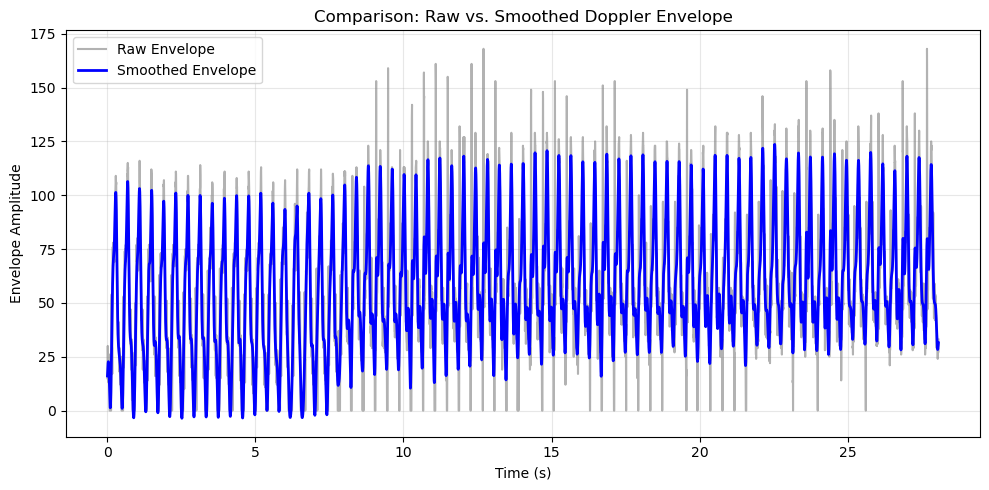

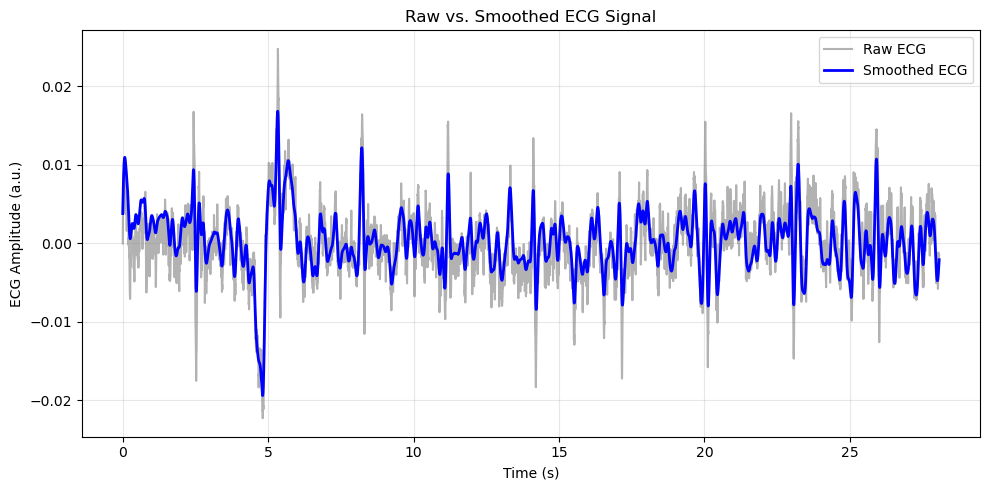

In [10]:
def plot_doppler(t, env_raw, env_smooth):
    plt.figure(figsize=(10, 5))
    plt.plot(t, env_raw, color='gray', alpha=0.6, label='Raw Envelope')
    plt.plot(t, env_smooth, color='blue', linewidth=2, label='Smoothed Envelope')
    plt.xlabel('Time (s)')
    plt.ylabel('Envelope Amplitude')
    plt.title('Comparison: Raw vs. Smoothed Doppler Envelope')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_ecg(t, ecg_raw, ecg_smooth):
    plt.figure(figsize=(10, 5))
    plt.plot(t, ecg_raw,   color='gray', alpha=0.6, label='Raw ECG')
    plt.plot(t, ecg_smooth, color='blue', linewidth=2, label='Smoothed ECG')
    plt.xlabel('Time (s)')
    plt.ylabel('ECG Amplitude (a.u.)')
    plt.title('Raw vs. Smoothed ECG Signal')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

FS_ECG_ORIG = 2048        # Hz
FS_TARGET   = 284         # Hz

ecg_raw, ecg_sm, ecg284, env_raw, env_sm = load_record(1, Path("/home/tsu25/envelops"), Path("/labs/katebilab/NinFEA_Data/Processed_Data"))
t = np.arange(len(env_sm), dtype=np.float32) / FS_TARGET
plot_doppler(t, env_raw, env_sm)

t_ecg = np.arange(len(ecg_sm), dtype=np.float32) / FS_ECG_ORIG
plot_ecg(t, ecg_raw, ecg_sm)

In [11]:
meta_data = pd.read_csv("/home/tsu25/Fetal-Maternal-Cardiac-Coupling/Deep_Learning/meta_data.csv")
meta_data['patient_id'] = range(1, len(meta_data)+1)
meta_data['signal_ids'] = meta_data['signal_ids'].apply(json.loads)
df_map = meta_data[['patient_id', 'signal_ids']].copy()

In [12]:
# map record id to patient id as a dictionary
df_long = (
    df_map
    .explode("signal_ids", ignore_index=True)
    .rename(columns={"signal_ids": "record_id"})
)

if df_long["record_id"].isna().any():
    raise ValueError("Some rows have empty signal_ids; fill or drop before proceeding.")

dupes = df_long.duplicated(subset=["record_id"], keep=False)
if dupes.any():
    clash = df_long.loc[dupes].sort_values("record_id")
    raise ValueError(f"Duplicate record_id assigned to multiple patients:\n{clash}")

rec_to_patient = dict(zip(df_long["record_id"].astype(int), df_long["patient_id"]))

In [14]:
WIN = int(WIN_SEC  * FS_TARGET)      # 3.75 s × 284 Hz = 1065
STEP = int(STEP_SEC * FS_TARGET)     # 50 % overlap

X, Y, PATIENT_IDS = [], [], []
for rec in range(1, 61):                
    _, _, ecg284, _, env = load_record(rec,
                              Path("/home/tsu25/envelops"),
                              Path("/labs/katebilab/NinFEA_Data/Processed_Data"))
    for s in range(0, len(env) - WIN, STEP):
        ecg_win = ecg284[s:s+WIN].astype(np.float32, copy=False)
        env_win = env[s:s+WIN].astype(np.float32, copy=False)

        # ECG per-window normalization
        ecg_win = (ecg_win - ecg_win.mean()) / (ecg_win.std() + 1e-6)

        # Doppler per-window normalization
        env_min, env_ptp = env_win.min(), env_win.ptp()
        env_win = 2.0 * (env_win - env_min)/(env_ptp + 1e-6) - 1.0  # [-1, 1]

        X.append(ecg_win[:, None])    # add channel dim
        Y.append(env_win)             # (WIN,)  or  env_win[:, None]
        patient_id = rec_to_patient[rec]
        PATIENT_IDS.append(patient_id)

X = np.asarray(X, dtype=np.float32)
Y = np.asarray(Y, dtype=np.float32)
PATIENT_IDS = np.asarray(PATIENT_IDS)
print("Final shapes:", X.shape, Y.shape, "Unique patient records:", np.unique(PATIENT_IDS).size)

Final shapes: (885, 1065, 1) (885, 1065) Unique patient records: 39


In [ ]:
# ECG_train, ECG_test, ENV_train, ENV_test = train_test_split(
#     X, Y, test_size=0.2, random_state=0, shuffle=True
# )

### Single patient-level train/val split

In [15]:
train_idx = np.load('/home/tsu25/ECG_PWD/Fetal-maternal-fusion/src/idx_train.npy')
val_idx = np.load('/home/tsu25/ECG_PWD/Fetal-maternal-fusion/src/idx_val.npy')

Model: "WaveNet_one_channel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ fetal_ecg_to_doppl… │ (None, 1065, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1065, 64)  │      1,344 │ fetal_ecg_to_dop… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1065, 64)  │      1,344 │ fetal_ecg_to_dop… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1065, 64)  │          0 │ conv1d[0][0],     │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1065, 64)  │        128 │ fetal_ecg_to_dop… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1065, 64)  │          0 │ multiply[0][0],   │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 1065, 64)  │     81,984 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 1065, 64)  │     81,984 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 1065, 64)  │          0 │ conv1d_4[0][0],   │
│ (Multiply)          │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 1065, 64)  │      4,160 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1065, 64)  │          0 │ multiply_1[0][0], │
│                     │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 1065, 64)  │     81,984 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 1065, 64)  │     81,984 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 1065, 64)  │          0 │ conv1d_8[0][0],   │
│ (Multiply)          │                   │            │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 1065, 64)  │      4,160 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1065, 64)  │          0 │ multiply_2[0][0], │
│                     │                   │            │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 1065, 64)  │          0 │ conv1d_12[0][0],  │
│ (Multiply)          │                   │            │ conv1d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 1065, 64)  │      4,160 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 1065, 64)  │          0 │ multiply_3[0][0]

 Total params: 1,040,769 (3.97 MB)

 Trainable params: 1,040,769 (3.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - loss: 0.4370 - val_loss: 0.4267
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 0.4078 - val_loss: 0.4229
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 0.4056 - val_loss: 0.4191
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 0.4046 - val_loss: 0.4111
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 0.3969 - val_loss: 0.4000
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 0.3906 - val_loss: 0.4063
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 0.3915 - val_loss: 0.3955
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 0.3767 - val_loss: 0.4011
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 0.3594 - val_loss: 0.4046
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 0.3467 - val_loss: 0.4160
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 0.3341 - val_loss: 0.4012
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 0.3231 - val_lo


Split results:
         split  train_patients  val_patients  train_segments  val_segments  best_val_loss
patient_split              31             8             693           192       0.395515


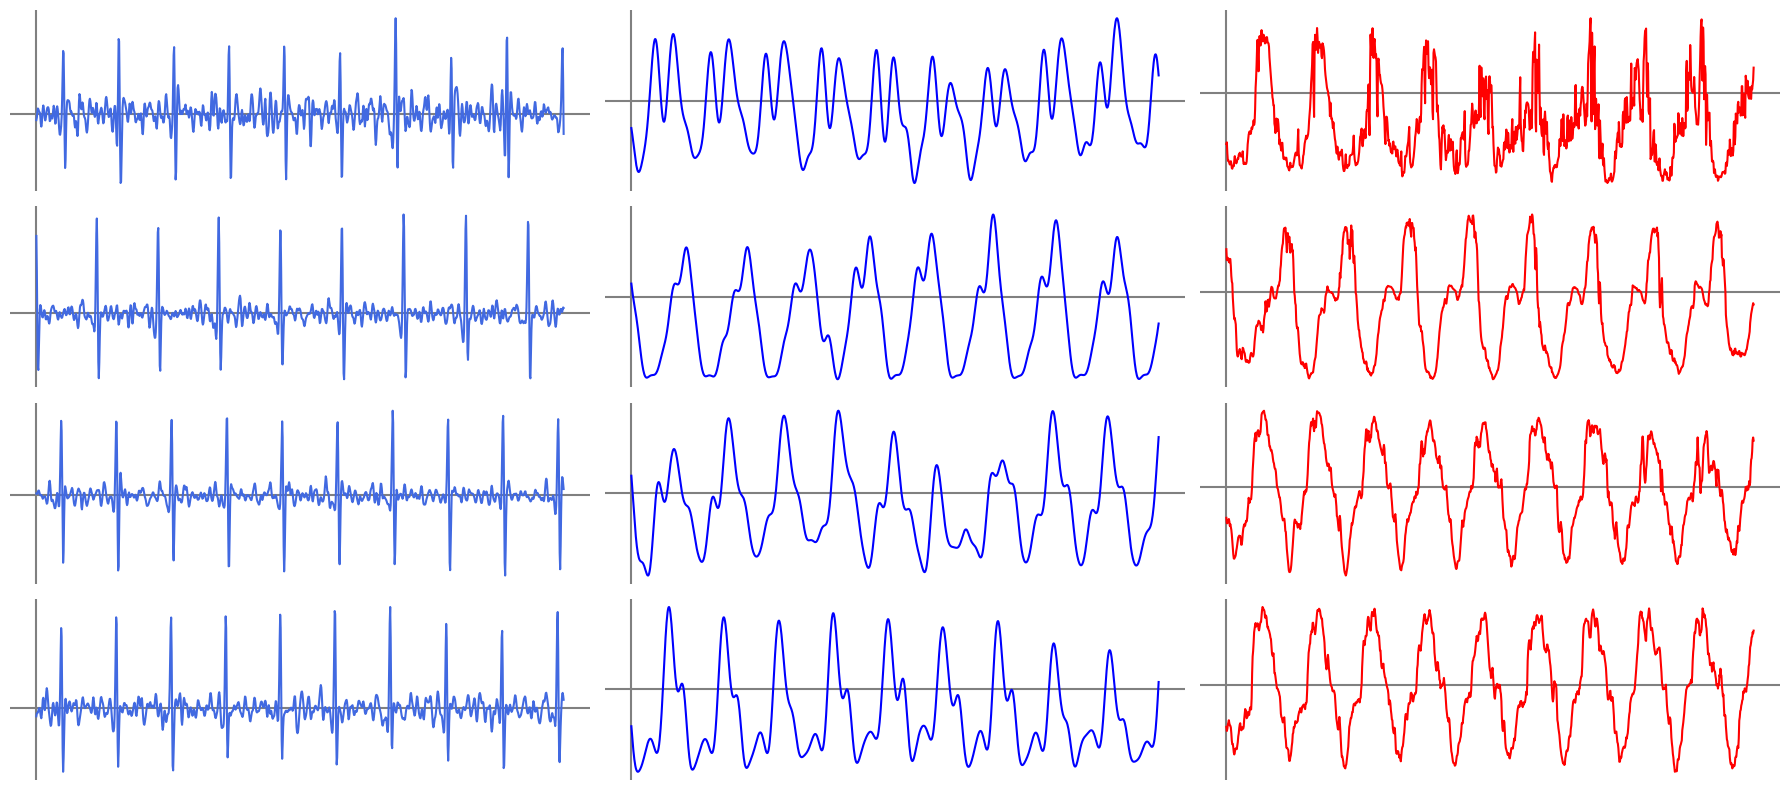

In [17]:
tr_pats = set(PATIENT_IDS[train_idx])                                    
va_pats = set(PATIENT_IDS[val_idx])                                      
assert tr_pats.isdisjoint(va_pats), "Patient leakage between train/val!" 

fold_rows = []            
best_val_losses = []     

save_dir_model = './WaveNet_beat/models'
save_dir_loss  = './WaveNet_beat/logs'
save_dir_plots = './WaveNet_beat/plots'
os.makedirs(save_dir_model, exist_ok=True)
os.makedirs(save_dir_loss,  exist_ok=True)
os.makedirs(save_dir_plots, exist_ok=True)

n_epochs = 20
batch_size = 32

latent_dim = WIN
model = modules.WaveNet_v2(input_shape=(latent_dim, 1))
model.compile(optimizer="adam", loss="mae")

history = model.fit(
    X[train_idx], Y[train_idx],
    validation_data=(X[val_idx], Y[val_idx]),
    epochs=n_epochs,
    batch_size=batch_size,
    verbose=1
)

val_losses = history.history.get('val_loss', [])
best_val = float(np.min(val_losses)) if len(val_losses) else float(model.evaluate(X[val_idx], Y[val_idx], verbose=0))
best_val_losses.append(best_val)

np.save(os.path.join(save_dir_loss, f'loss_split.npy'),     history.history['loss'])   
np.save(os.path.join(save_dir_loss, f'val_loss_split.npy'), val_losses)                
model.save(os.path.join(save_dir_model, f'model_patient_split.h5'))                    

train_patients = np.unique(PATIENT_IDS[train_idx])   
val_patients   = np.unique(PATIENT_IDS[val_idx])    

fold_rows.append({
    "split": "patient_split",                        
    "train_patients": train_patients.size,
    "val_patients":   val_patients.size,
    "train_segments": train_idx.size,
    "val_segments":   val_idx.size,
    "best_val_loss":  best_val
})

# Table(s)
df_split = pd.DataFrame(fold_rows)
print("\nSplit results:\n", df_split.to_string(index=False))

# qualitative plots on the validation set
if val_idx.size >= 4:
    #rng = np.random.default_rng(0)
    #rand_val_idx = rng.choice(val_idx, size=4, replace=False)
    #showcase_idx_file = os.path.join(save_dir_plots, "val_showcase_idx.npy")
    #np.save(showcase_idx_file, rand_val_idx)

    rand_val_idx = np.load('/home/tsu25/ECG_PWD/Fetal-maternal-fusion/src/WaveNet_beat/plots/val_showcase_idx.npy')
    selected_ecgs = X[rand_val_idx]
    selected_real_dopplers = Y[rand_val_idx]
    generated_dopplers = model.predict(selected_ecgs, verbose=0).squeeze(-1)

    modules.plot_ecg_doppler_pairs(selected_ecgs, selected_real_dopplers, generated_dopplers)
    #modules.plot_scalogram(selected_real_dopplers, generated_dopplers)

### Model Training

In [ ]:
# Set latent dimension to window size for input
latent_dim = WIN
WaveNet = modules.WaveNet_v2(input_shape=(latent_dim, 1))
WaveNet.compile(optimizer="adam", loss="mae")

n_epochs = 30

history = WaveNet.fit(ECG_train,
                      ENV_train,
                      epochs=n_epochs,
                      batch_size=32,
                      validation_split=0.1)

save_dir_model = './WaveNet_beat/models'
save_dir_loss = './WaveNet_beat/logs'
save_dir_plots = './WaveNet_beat/plots'
os.makedirs(save_dir_model, exist_ok=True)
WaveNet.save(os.path.join(save_dir_model, 'model_v3.h5'))

os.makedirs(save_dir_loss, exist_ok=True)
np.save(os.path.join(save_dir_loss, 'loss_1.npy'), history.history['loss'])

os.makedirs(save_dir_plots, exist_ok=True)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('./WaveNet_beat/plots/loss_3.png')
plt.show()

# Show some random generated
# Randomly select 4 ECG samples and their corresponding real Doppler from the dataset
random_indices = np.random.choice(len(ECG_test), 4, replace=False)
selected_ecgs = ECG_test[random_indices]
selected_real_dopplers = ENV_test[random_indices]
# Generate Doppler using the model
generated_dopplers = WaveNet.predict(selected_ecgs).squeeze(-1)
# Plot the selected ECGs, real Dopplers, and their corresponding generated Doppler signals
modules.plot_ecg_doppler_pairs(selected_ecgs, selected_real_dopplers, generated_dopplers)
modules.plot_scalogram(selected_real_dopplers, generated_dopplers)

Model: "WaveNet_one_channel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ fetal_ecg_to_doppl… │ (None, 1065, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1065, 64)  │      1,344 │ fetal_ecg_to_dop… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1065, 64)  │      1,344 │ fetal_ecg_to_dop… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1065, 64)  │          0 │ conv1d[0][0],     │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 1065, 64)  │        128 │ fetal_ecg_to_dop… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1065, 64)  │          0 │ multiply[0][0],   │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 1065, 64)  │     81,984 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 1065, 64)  │     81,984 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 1065, 64)  │          0 │ conv1d_4[0][0],   │
│ (Multiply)          │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 1065, 64)  │      4,160 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1065, 64)  │          0 │ multiply_1[0][0], │
│                     │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 1065, 64)  │     81,984 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 1065, 64)  │     81,984 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 1065, 64)  │          0 │ conv1d_8[0][0],   │
│ (Multiply)          │                   │            │ conv1d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 1065, 64)  │      4,160 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1065, 64)  │          0 │ multiply_2[0][0], │
│                     │                   │            │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 1065, 64)  │          0 │ conv1d_12[0][0],  │
│ (Multiply)          │                   │            │ conv1d_13[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 1065, 64)  │      4,160 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 1065, 64)  │          0 │ multiply_3[0][0]

 Total params: 1,040,769 (3.97 MB)

 Trainable params: 1,040,769 (3.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - loss: 0.4398 - val_loss: 0.4209
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - loss: 0.4106 - val_loss: 0.4159
Epoch 3/30
18/20 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - loss: 0.4094

KeyboardInterrupt: 

### Evaluation

In [9]:
# ---------- helper that builds an Activation layer regardless of config -----
def _act_builder(act_fn):
    # Keras deserializer calls obj(**config); we pop unknown keys here
    return lambda **cfg: tf.keras.layers.Activation(
        act_fn,
        name=cfg.pop("name", None),           # keep layer name if present
        trainable=cfg.pop("trainable", True)  # default True
    )

custom_objects = {
    "Tanh":      _act_builder(tf.keras.activations.tanh),
    "Relu":      _act_builder(tf.keras.activations.relu),
    "Silu":      _act_builder(tf.keras.activations.silu),
    "Sigmoid":   _act_builder(tf.keras.activations.sigmoid),
    "Softmax":   _act_builder(tf.keras.activations.softmax),
    # LeakyReLU is already a dedicated layer class, expose it directly
    "LeakyRelu": lambda **cfg: tf.keras.layers.LeakyReLU(
        negative_slope=cfg.pop("alpha", 0.2),  # Keras uses `negative_slope`
        name=cfg.pop("name", None),
        **cfg                                    # trainable, dtype, etc.
    ),
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step


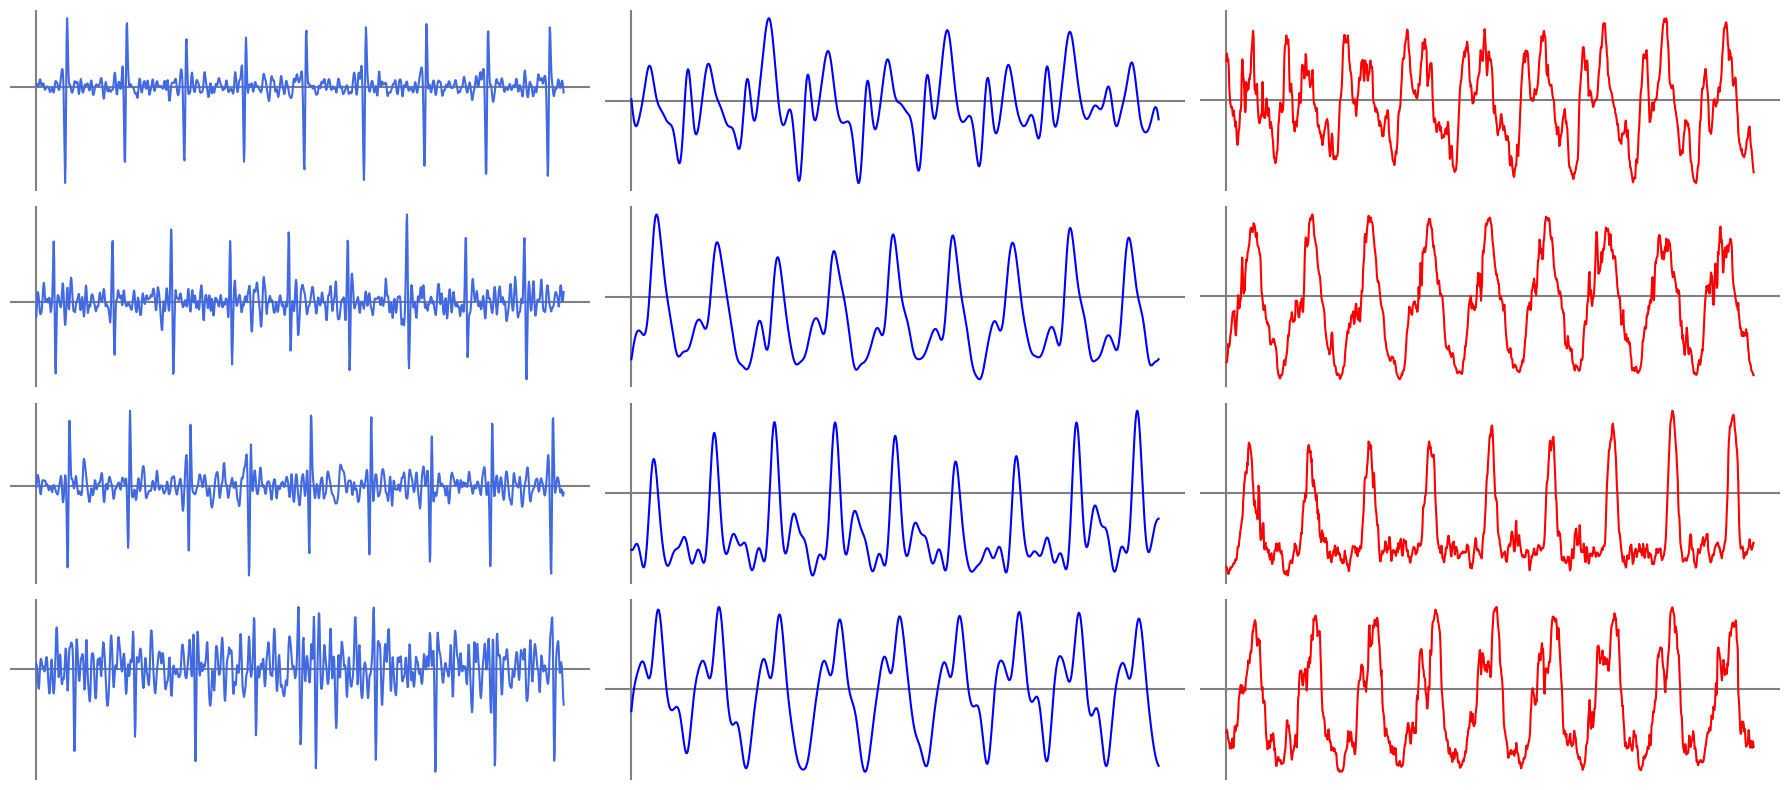

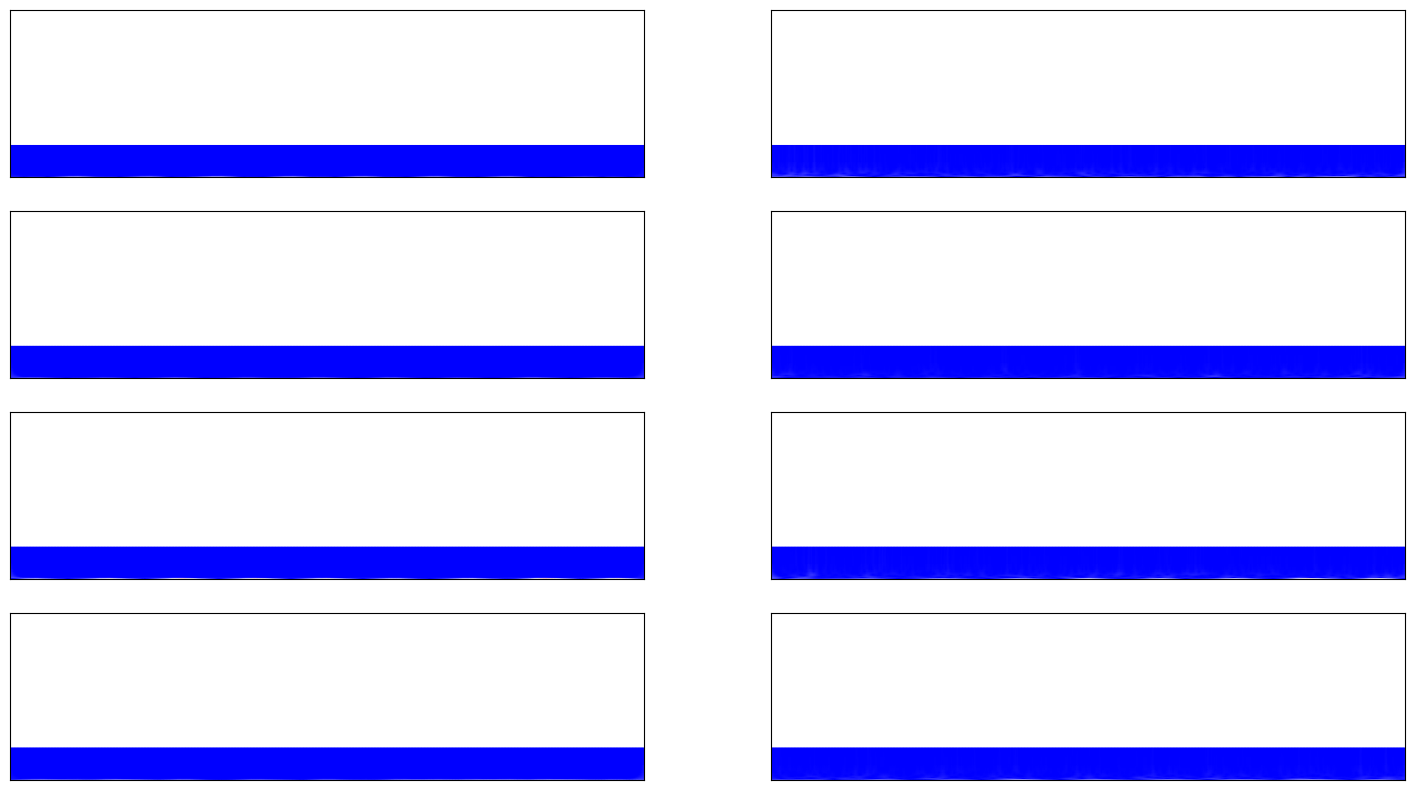

In [11]:
model_path = Path("./WaveNet_beat/models/model_v3.h5")
WaveNet = tf.keras.models.load_model(model_path, custom_objects=custom_objects, compile=False)


save_dir_plots = './WaveNet_beat/plots'
os.makedirs(save_dir_plots, exist_ok=True)

# Show some random generated
# Randomly select 4 ECG samples and their corresponding real Doppler from the dataset
random_indices = np.random.choice(len(ECG_test), 4, replace=False)
selected_ecgs = ECG_test[random_indices]
selected_real_dopplers = ENV_test[random_indices]
# Generate Doppler using the model
generated_dopplers = WaveNet.predict(selected_ecgs).squeeze(-1)
# Plot the selected ECGs, real Dopplers, and their corresponding generated Doppler signals
modules.plot_ecg_doppler_pairs(selected_ecgs, selected_real_dopplers, generated_dopplers)
modules.plot_scalogram(selected_real_dopplers, generated_dopplers)

In [12]:
# WaveNet outputs (batch, 1065, 1).  Squeeze to 2-D for metric calls
generated_dopplers = WaveNet.predict(ECG_test, batch_size=64).squeeze(-1)
DUS_array_test = ENV_test

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


In [13]:
# Calculate metrics
rmse = calculate_rmse(generated_dopplers, DUS_array_test)
mae = calculate_mae(generated_dopplers, DUS_array_test)
kld = calculate_kld(generated_dopplers, DUS_array_test)
dtw_distance = calculate_dtw(generated_dopplers, DUS_array_test)
correlation = calculate_correlation(generated_dopplers, DUS_array_test)
sdtw = calculate_soft_dtw(generated_dopplers, DUS_array_test)
ed = calculate_euclidean_distance(generated_dopplers, DUS_array_test)
rdd = calculate_rdd(generated_dopplers, DUS_array_test)
prd = calculate_prd(generated_dopplers, DUS_array_test)
entropy = calculate_spectral_entropy(generated_dopplers, DUS_array_test)
psd = calculate_psd_difference(generated_dopplers, DUS_array_test)
centroid = calculate_spectral_centroid_difference(generated_dopplers, DUS_array_test)
flatness = calculate_flatness_difference(generated_dopplers, DUS_array_test)
fd = calculate_discrete_frechet_distance(generated_dopplers, DUS_array_test)

# Print results
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"KLD: {kld}")
print(f"DTW Distance: {dtw_distance}")
print(f"Correlation: {correlation}")
print(f"Soft DTW: {sdtw}")
print(f"ED: {ed}")
print(f"RDD: {rdd}")
print(f"prd: {prd}")
print(f"spectral entropy: {entropy}")
print(f"psd difference: {psd}")
print(f"centroid difference: {centroid}")
print(f"spectral flatness: {flatness}")
print(f"fd: {fd}")

RMSE: 0.33695852756500244
MAE: 0.2486354410648346
KLD: 0.029695459219484934
DTW Distance: 1829.429809965528
Correlation: 0.7482076481207383
Soft DTW: 21403.052734375
ED: 146.29779052734375
RDD: 4882.955508474576
prd: 64.26037549972534
spectral entropy: 0.07596206665039062
psd difference: 0.01714416593313217
centroid difference: 10.58498275916264
spectral flatness: 0.024074668064713478
fd: 6.982143878936768


In [10]:
import pandas as pd

metrics = [
    ("RMSE",               0.3981609642505646,  "Moderate point-wise error (≈ 20 % scale)"),
    ("MAE",                0.30351194739341736, "Typical absolute deviation per sample"),
    ("KLD",                0.1525541972389974,  "Amplitude distribution close; small divergence"),
    ("DTW",                2270.005806179246,   "Avg. mis-alignment ≈ 2 samples (warped)"),
    ("Pearson r",          0.5534738365210246,  "Medium linear similarity"),
    ("Soft-DTW",           29884.1015625,       "Residual timing/shape mismatch remains"),
    ("Euclidean dist.",    172.8701629638672,   "Cumulative point-wise error energy"),
    ("RDD",                9.590573044429379e9, "Scale-sensitive; inflated by small denom."),
    ("PRD",                75.98966360092163,   "Error energy still high; noticeable distortion"),
    ("Spectral entropy Δ", 0.7945833206176758,  "Generated PSD flatter (peaks lost)"),
    ("PSD ℓ2 Δ",           0.033398982137441635,"Overall spectra fairly close"),
    ("Centroid Δ",         24.94859342651444,   "Energy shifted higher; less low-freq content"),
    ("Flatness Δ",         0.31084978580474854, "Generated envelopes noisier / less tonal"),
    ("Fréchet dist.",      10.08528995513916,   "Global shape drift remains")
]

df_metrics = pd.DataFrame(metrics, columns=["Metric", "Value", "Interpretation"])
df_metrics["Value"] = df_metrics["Value"].map("{:.6f}".format)

In [11]:
df_metrics

,Metric,Value,Interpretation
0,RMSE,0.398161,Moderate point-wise error (≈ 20 % scale)
1,MAE,0.303512,Typical absolute deviation per sample
2,KLD,0.152554,Amplitude distribution close; small divergence
3,DTW,2270.005806,Avg. mis-alignment ≈ 2 samples (warped)
4,Pearson r,0.553474,Medium linear similarity
5,Soft-DTW,29884.101562,Residual timing/shape mismatch remains
6,Euclidean dist.,172.870163,Cumulative point-wise error energy
7,RDD,9590573044.429379,Scale-sensitive; inflated by small denom.
8,PRD,75.989664,Error energy still high; noticeable distortion
9,Spectral entropy Δ,0.794583,Generated PSD flatter (peaks lost)
